/Users/jhanavi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Loading Data...
Data ready! Total hours processed: 17538
Training shapes: X=(14011, 24, 1), y=(14011, 1)
Building LSTM Model...


/var/folders/9z/qp22zvwx5gs7_ny2l7pgb9jw0000gn/T/ipykernel_8729/2657602826.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=df_grouped.index.min(), end=df_grouped.index.max(), freq='H')
2026-01-05 12:56:49.508148: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-05 12:56:49.508207: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-05 12:56:49.508219: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-01-05 12:56:49.508280: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-05 12:56:49.508298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 

Epoch 1/20


2026-01-05 12:56:51.520786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


438/438 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0054 - val_loss: 0.0060
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0054 - val_loss: 0.0058
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0054 - val_loss: 0.0061
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0054 - val_loss: 0.0059
Epoch 11/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 12/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/st

Saved forecast_plot.png
Model saved to models/lstm_demand_model.h5
Predictions exported to data/predicted_demand_output.csv


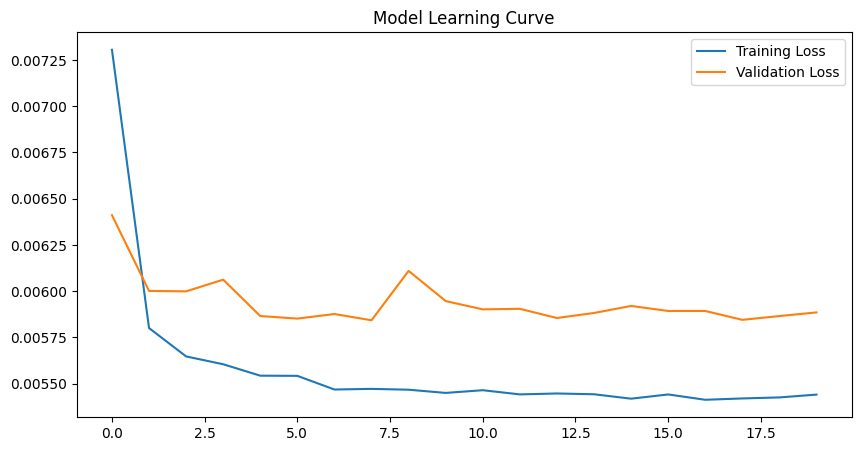

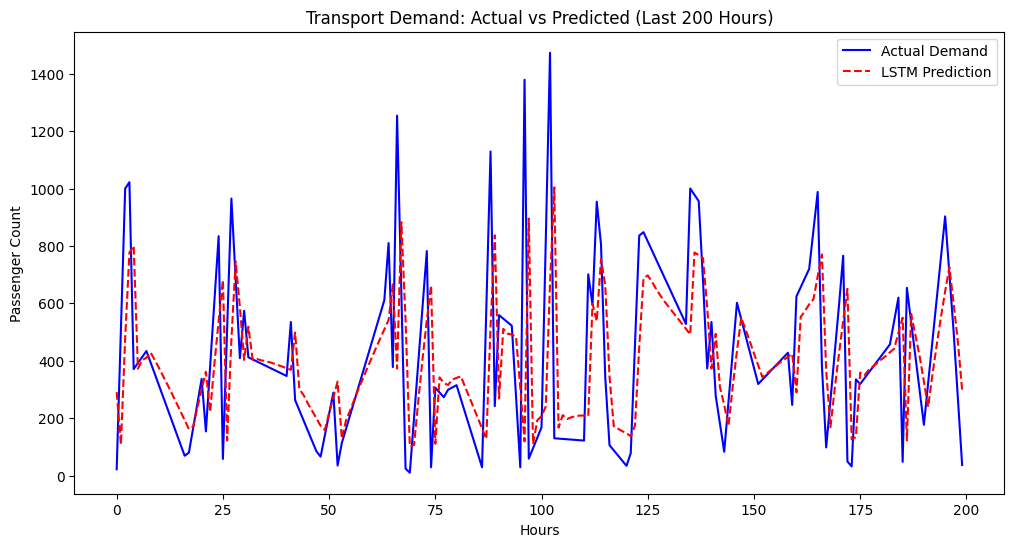

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- 1. DATA PREPARATION ---
print("Loading Data...")
# Load ridership data
df = pd.read_csv('data/ridership.csv')

# Convert Date/Time columns
df['Date'] = pd.to_datetime(df['Date'])
df['Time_Hour'] = df['Time_Hour'].astype(int)

# Aggregate to "Total City Demand" per hour (Summing all routes together)
# This creates a single time-series line, which is best for LSTM
df_grouped = df.groupby(['Date', 'Time_Hour'])['Passengers'].sum().reset_index()

# Create a proper datetime index
df_grouped['Datetime'] = pd.to_datetime(df_grouped['Date'].astype(str) + ' ' + df_grouped['Time_Hour'].astype(str) + ':00:00')
df_grouped = df_grouped.set_index('Datetime').sort_index()

# HANDLE GAPS: Real data has missing hours. We must fill them for LSTM to work.
# We create a full timeline range and fill missing spots with interpolated values.
full_range = pd.date_range(start=df_grouped.index.min(), end=df_grouped.index.max(), freq='H')
df_clean = df_grouped.reindex(full_range)
df_clean['Passengers'] = df_clean['Passengers'].interpolate(method='linear')

print(f"Data ready! Total hours processed: {len(df_clean)}")

# --- 2. PREPARING SEQUENCES FOR LSTM ---
# LSTM needs data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df_clean[['Passengers']])

def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length]) # Input: Previous 24 hours
        y.append(data[i+seq_length])   # Output: Next 1 hour
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # Look back 24 hours
X, y = create_sequences(dataset, SEQ_LENGTH)

# Split into Train (80%) and Test (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")

# --- 3. BUILDING THE LSTM MODEL ---
print("Building LSTM Model...")
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, 1)), # Layer 1: Learn patterns
    Dropout(0.2), # Prevent overfitting
    LSTM(50, return_sequences=False), # Layer 2: Refine patterns
    Dropout(0.2),
    Dense(1) # Output layer: Predict 1 number (Passengers)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# --- 4. EVALUATION & VISUALIZATION ---
# Make predictions
predictions = model.predict(X_test)
# Convert back from "0-1" scale to "Real Passenger Numbers"
predictions_real = scaler.inverse_transform(predictions)
y_test_real = scaler.inverse_transform(y_test)

# Calculate Accuracy
mae = mean_absolute_error(y_test_real, predictions_real)
print(f"Mean Absolute Error: {mae:.2f} passengers")

# PLOT 1: Training History
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.legend()
plt.savefig('learning_curve.png') # Saves image
print("Saved learning_curve.png")

# PLOT 2: Prediction vs Actual (Zoom in on last 200 hours)
plt.figure(figsize=(12, 6))
plt.plot(y_test_real[-200:], label='Actual Demand', color='blue')
plt.plot(predictions_real[-200:], label='LSTM Prediction', color='red', linestyle='--')
plt.title('Transport Demand: Actual vs Predicted (Last 200 Hours)')
plt.legend()
plt.xlabel('Hours')
plt.ylabel('Passenger Count')
plt.savefig('forecast_plot.png') # Saves image
print("Saved forecast_plot.png")

# --- 5. SAVE FOR NEXT MEMBER ---
# Save the trained model
model.save('models/lstm_demand_model.h5')
print("Model saved to models/lstm_demand_model.h5")

# Export predictions for Member 3 (Pricing) to use
output_df = pd.DataFrame({
    'Actual_Demand': y_test_real.flatten(),
    'Predicted_Demand': predictions_real.flatten()
})
output_df.to_csv('data/predicted_demand_output.csv', index=False)
print("Predictions exported to data/predicted_demand_output.csv")

In [ ]:
pip install "numpy<2.0"

In [ ]:
pip install tensorflow-macos tensorflow-metal pandas numpy scikit-learn matplotlib